In [63]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models
import time
import copy
import numpy as np
import os

In [64]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [65]:
data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [66]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()



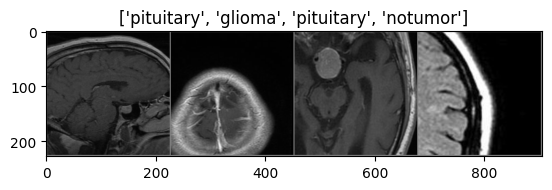

In [67]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [68]:
# class CNNNet(nn.Module):
#     def __init__(self):
#         super(CNNNet,self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3,stride=2),
            
#             nn.Conv2d(64,192,kernel_size=5,padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3,stride=2),
            
#             nn.Conv2d(192,256,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3,stride=2)
            
            
            
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6,6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256*6*6,4096),
#             nn.ReLU(),
#             nn.Dropout(),
#             nn.Linear(4096,4)
#         )
#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x
            

In [69]:
model = models.resnet18(pretrained = True)

/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,4)

In [71]:
optimizer = optim.SGD(model.parameters(),lr=0.001,weight_decay=0.03)

In [72]:
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [73]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [74]:
# def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=30, device="cpu"):
#     for epoch in range(1, epochs+1):
#         training_loss = 0.0
#         valid_loss = 0.0
#         model.train()
#         for batch in train_loader:
#             optimizer.zero_grad()
#             inputs, targets = batch
#             inputs = inputs.to(device)
#             targets = targets.to(device)
#             output = model(inputs)
#             loss = loss_fn(output, targets)
#             loss.backward()
#             optimizer.step()
#             training_loss += loss.data.item() * inputs.size(0)
#         training_loss /= len(train_loader.dataset)
        
#         model.eval()
#         num_correct = 0 
#         num_examples = 0
#         for batch in val_loader:
#             inputs, targets = batch
#             inputs = inputs.to(device)
#             output = model(inputs)
#             targets = targets.to(device)
#             loss = loss_fn(output,targets) 
#             valid_loss += loss.data.item() * inputs.size(0)
#             correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1],
#                                targets)
#             num_correct += torch.sum(correct).item()
#             num_examples += correct.shape[0]
#         valid_loss /= len(val_loader.dataset)
#         scheduler.step(valid_loss)

#         print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
#         valid_loss, num_correct / num_examples))

In [75]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [76]:
criterion = nn.CrossEntropyLoss()

In [77]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [79]:
# train(model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=30, device=device)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3883 Acc: 0.8657
val Loss: 0.1405 Acc: 0.9460

Epoch 1/4
----------
train Loss: 0.3566 Acc: 0.8827
val Loss: 0.1435 Acc: 0.9390

Epoch 2/4
----------
train Loss: 0.3441 Acc: 0.8811
val Loss: 0.1062 Acc: 0.9531

Epoch 3/4
----------
train Loss: 0.3288 Acc: 0.8930
val Loss: 0.1033 Acc: 0.9648

Epoch 4/4
----------
train Loss: 0.3306 Acc: 0.8920
val Loss: 0.0941 Acc: 0.9718

Training complete in 46m 19s
Best val Acc: 0.971831


In [80]:
torch.save(model,'brain_tumor_one.pth')